# Regularization and Optimization of Neural Networks - Lab

## Introduction

Recall from the last lab that we had a training accuracy close to 90% and a test set accuracy close to 76%.

As with our previous machine learning work, we should be asking a couple of questions:
- Is there a high bias? yes/no
- Is there a high variance? yes/no

Also recall that "high bias" is a relative concept. Knowing we have 7 classes and the topics are related, we'll assume that a 90% accuracy is pretty good and the bias on the training set is low. (We've also discussed concepts like precision, recall as well as AUC and ROC curves.)   

In this lab, we'll use the notion of training/validation/test set to get better insights of how we can mitigate our variance, and we'll look at a few regularization techniques. You'll start by repeating the process from the last section: importing the data and performing preprocessing including one-hot encoding. Then, just before you go on to train the model, we'll introduce how to include a validation set. You'll then define and compile the model as before. This time, when you are presented with the `history` dictionary of the model, you will have additional data entries for not only the train and test, but the train, test and validation  and then defigning, compiling and training the model. 


## Objectives

You will be able to:

* Construct and run a basic model in Keras
* Construct a validation set and explain potential benefits
* Apply L1 and L2 regularization
* Aplly dropout regularization
* Observe and comment on the effect of using more data

## Import the libraries

As usual, start by importing some of the packages and modules that you intend to use. The first thing we'll be doing is importing the data and taking a random sample, so that should clue you in to what tools to import. If you need more tools down the line, you can always import additional packages later.

In [1]:
#Your code here; import some packages/modules you plan to use
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn import preprocessing
from keras.preprocessing.text import Tokenizer
from keras import models
from keras import layers
from keras import optimizers

Using TensorFlow backend.


## Load the Data

As with the previous lab, the data is stored in a file **Bank_complaints.csv**. Load and preview the dataset.

In [2]:
#Your code here; load and preview the dataset
raw_df = pd.read_csv('Bank_complaints.csv')
raw_df.head()

,Product,Consumer complaint narrative
0,Student loan,In XX/XX/XXXX I filled out the Fedlaon applica...
1,Student loan,I am being contacted by a debt collector for p...
2,Student loan,I cosigned XXXX student loans at SallieMae for...
3,Student loan,Navient has sytematically and illegally failed...
4,Student loan,My wife became eligible for XXXX Loan Forgiven...


## Preprocessing Overview

Before we begin to practice some of our new tools regarding regularization and optimization, let's practice munging some data as we did in the previous section with bank complaints. Recall some techniques:

* Sampling in order to reduce training time (investigate model accuracy vs data size later on)
* One-hot encoding our complaint text
* Transforming our category labels
* Train - test split

## Preprocessing: Generate a Random Sample

Since we have quite a bit of data and training networks takes a substantial amount of time and resources, we will downsample in order to test our initial pipeline. Going forward, these can be interesting areas of investigation: how does our models performance change as we increase (or decrease) the size of our dataset?  

Generate the random sample using seed 123 for consistency of results. Make your new sample have 10,000 observations.

In [5]:
#Your code here
sample_df = raw_df.sample(n = 10000, random_state = 123)

## Preprocessing: One-hot Encoding of the Complaints

As before, we need to do some preprocessing and data manipulationg before building the neural network. Last time, we guided you through the process, and now its time for you to practice that pipeline independently.  

Only keep 2,000 most common words and use one-hot encoding to reformat the complaints into a matrix of vectors.

In [6]:
#Your code here; use one-hot encoding to reformat the complaints into a matrix of vectors.
#Only keep the 2000 most common words.
complaints = sample_df["Consumer complaint narrative"] #Our raw text complaints

tokenizer = Tokenizer(num_words=2000) #Initialize a tokenizer.

tokenizer.fit_on_texts(complaints) #Fit it to the complaints

sequences = tokenizer.texts_to_sequences(complaints) #Generate sequences
print('sequences type:', type(sequences))

one_hot_results= tokenizer.texts_to_matrix(complaints, mode='binary') #Similar to sequences, but returns a numpy array
print('one_hot_results type:', type(one_hot_results))

word_index = tokenizer.word_index #Useful if we wish to decode (more explanation below)

print('Found %s unique tokens.' % len(word_index)) #Tokens are the number of unique words across the corpus


print('Dimensions of our coded results:', np.shape(one_hot_results)) #Our coded data

sequences type: <class 'list'>
one_hot_results type: <class 'numpy.ndarray'>
Found 21527 unique tokens.
Dimensions of our coded results: (10000, 2000)


## Preprocessing: Encoding the Products

Similarly, now transform the descriptive product labels to integers labels. After transforming them to integer labels, retransform them into a matrix of binary flags, one for each of the various product labels.  
  
  (Note: this is similar to our previous work with dummy variables: each of the various product categories will be its own column, and each observation will be a row. Each of these observation rows will have a 1 in the column associated with it's label, and all other entries for the row will be zero.)

In [7]:
#Your code here; transform the product labels to numerical values
#Then transform these integer values into a matrix of binary flags
product = sample_df["Product"]

le = preprocessing.LabelEncoder() #Initialize. le used as abbreviation fo label encoder
le.fit(product)
print("Original class labels:")
print(list(le.classes_))
print('\n')
product_cat = le.transform(product)  
#list(le.inverse_transform([0, 1, 3, 3, 0, 6, 4])) #If you wish to retrieve the original descriptive labels post production

print('New product labels:')
print(product_cat)
print('\n')


print('One hot labels; 7 binary columns, one for each of the categories.') #Each row will be all zeros except for the category for that observation.
product_onehot = to_categorical(product_cat)
print(product_onehot)
print('\n')

print('One hot labels shape:')
print(np.shape(product_onehot))

Original class labels:
['Bank account or service', 'Checking or savings account', 'Consumer Loan', 'Credit card', 'Credit reporting', 'Mortgage', 'Student loan']


New product labels:
[2 0 0 ... 0 6 6]


One hot labels; 7 binary columns, one for each of the categories.
[[0. 0. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


One hot labels shape:
(10000, 7)


## Train-test Split

Now onto the ever familiar train-test split! Be sure to split both the complaint data (now transformed into word vectors) as well as their associated labels. Perform an appropriate train test split.

In [8]:
#Your code here
import random
random.seed(123)
test_index = random.sample(range(1,10000), 1000)

X_test = one_hot_results[test_index]
X_train = np.delete(one_hot_results, test_index, 0)

y_test = product_onehot[test_index]
y_train = np.delete(product_onehot, test_index, 0)

print("Test label shape:", np.shape(X_test))
print("Train label shape:", np.shape(X_train))
print("Test shape:", np.shape(y_test))
print("Train shape:", np.shape(y_train))

Test label shape: (1000, 2000)
Train label shape: (9000, 2000)
Test shape: (1000, 7)
Train shape: (9000, 7)


## Running the model using a validation set.

## Creating the Validation Set

In the lecture we mentioned that in deep learning, we generally keep aside a validation set, which is used during hyperparameter tuning. Then when we have made the final model decision, the test set is used to define the final model perforance. 

In this example, let's take the first 1000 cases out of the training set to become the validation set. You should do this for both `train` and `label_train`.

In [9]:
#Just run this block of code 
random.seed(123)
val = X_train[:1000]
train_final = X_train[1000:]
label_val = y_train[:1000]
label_train_final = y_train[1000:]

## Creating the Model

Let's rebuild a fully connected (Dense) layer network with relu activations in Keras.

Recall that we used 2 hidden with 50 units in the first layer and 25 in the second, both with a `relu` activation function. Because we are dealing with a multiclass problem (classifying the complaints into 7 classes), we use a use a softmax classifyer in order to output 7 class probabilities per case.  



In [11]:
#Your code here; build a neural network using Keras as described above.
from keras.models import Sequential
from keras.layers import Dense

# create model
model = models.Sequential()
model.add(Dense(50, input_dim=2000, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(7, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.


## Compiling the Model
In the compiler, you'll be passing the optimizer, loss function, and metrics. Train the model for 120 epochs in mini-batches of 256 samples. This time, let's include the argument `validation_data` and assign it `(val, label_val)`

In [16]:
#Your code here
model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Part 2: Code Along

The remaining portion of this lab will introduce you to code snippets for a myriad of different methods discussed in the lecture.

## Training the Model

Ok, now for the resource intensive part: time to train our model! Note that this is where we also introduce the validation data to the model.

In [17]:
#Code provided; note the extra validation parameter passed.
model_val = model.fit(train_final,
                    label_train_final,
                    epochs=120,
                    batch_size=256,
                    validation_data = (val, label_val))

Train on 8000 samples, validate on 1000 samples
Epoch 1/120
8000/8000 [==============================] - 1s 102us/step - loss: 1.9498 - acc: 0.1644 - val_loss: 1.9383 - val_acc: 0.1710
Epoch 2/120
8000/8000 [==============================] - 0s 43us/step - loss: 1.9261 - acc: 0.2064 - val_loss: 1.9201 - val_acc: 0.2170
Epoch 3/120
8000/8000 [==============================] - 0s 41us/step - loss: 1.9089 - acc: 0.2364 - val_loss: 1.9025 - val_acc: 0.2440
Epoch 4/120
8000/8000 [==============================] - 0s 43us/step - loss: 1.8899 - acc: 0.2567 - val_loss: 1.8816 - val_acc: 0.2700
Epoch 5/120
8000/8000 [==============================] - 0s 41us/step - loss: 1.8661 - acc: 0.2833 - val_loss: 1.8553 - val_acc: 0.2900
Epoch 6/120
8000/8000 [==============================] - 0s 41us/step - loss: 1.8350 - acc: 0.3100 - val_loss: 1.8221 - val_acc: 0.3170
Epoch 7/120
8000/8000 [==============================] - 0s 42us/step - loss: 1.7961 - acc: 0.3389 - val_loss: 1.7798 - val_acc: 0.3340

Epoch 60/120
8000/8000 [==============================] - 0s 41us/step - loss: 0.5402 - acc: 0.8120 - val_loss: 0.6774 - val_acc: 0.7420
Epoch 61/120
8000/8000 [==============================] - 0s 41us/step - loss: 0.5357 - acc: 0.8136 - val_loss: 0.6756 - val_acc: 0.7470
Epoch 62/120
8000/8000 [==============================] - 0s 40us/step - loss: 0.5310 - acc: 0.8134 - val_loss: 0.6715 - val_acc: 0.7430
Epoch 63/120
8000/8000 [==============================] - 0s 42us/step - loss: 0.5258 - acc: 0.8184 - val_loss: 0.6723 - val_acc: 0.7400
Epoch 64/120
8000/8000 [==============================] - 0s 41us/step - loss: 0.5214 - acc: 0.8219 - val_loss: 0.6702 - val_acc: 0.7440
Epoch 65/120
8000/8000 [==============================] - 0s 43us/step - loss: 0.5168 - acc: 0.8211 - val_loss: 0.6650 - val_acc: 0.7390
Epoch 66/120
8000/8000 [==============================] - 0s 41us/step - loss: 0.5121 - acc: 0.8226 - val_loss: 0.6685 - val_acc: 0.7390
Epoch 67/120
8000/8000 [=================

8000/8000 [==============================] - 0s 39us/step - loss: 0.3431 - acc: 0.8949 - val_loss: 0.6576 - val_acc: 0.7560
Epoch 120/120
8000/8000 [==============================] - ETA: 0s - loss: 0.3413 - acc: 0.893 - 0s 39us/step - loss: 0.3405 - acc: 0.8940 - val_loss: 0.6628 - val_acc: 0.7540


## Retrieving Performance Results: the `history` dictionary

The dictionary `history` contains four entries this time: one per metric that was being monitored during training and during validation.

In [18]:
model_val_dict = model_val.history
model_val_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [19]:
results_train = model.evaluate(train_final, label_train_final)

8000/8000 [==============================] - 0s 29us/step


In [20]:
results_test = model.evaluate(X_test, y_test)

1000/1000 [==============================] - 0s 31us/step


In [21]:
results_train

[0.3418060435056686, 0.89]

In [22]:
results_test

[0.6446828603744507, 0.765]

Note that the result isn't exactly the same as before. Note that this because the training set is slightly different! We remove 1000 instances for validation!

## Plotting the Results

Let's plot the result similarly to what we have done in the previous lab. This time though, let's include the training and the validation loss in the same plot. We'll do the same thing for the training and validation accuracy.

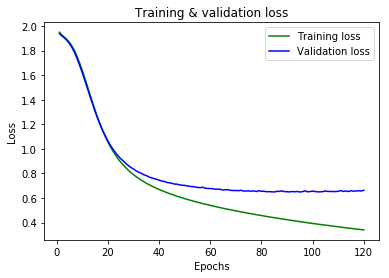

In [23]:
plt.clf()

import matplotlib.pyplot as plt
loss_values = model_val_dict['loss']
val_loss_values = model_val_dict['val_loss']

epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'g', label='Training loss')
plt.plot(epochs, val_loss_values, 'blue', label='Validation loss')

plt.title('Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

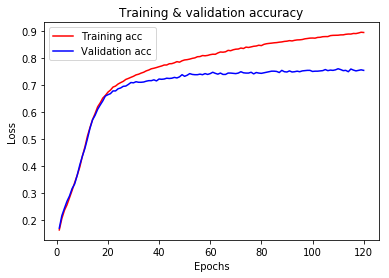

In [24]:
plt.clf()

acc_values = model_val_dict['acc'] 
val_acc_values = model_val_dict['val_acc']

plt.plot(epochs, acc_values, 'r', label='Training acc')
plt.plot(epochs, val_acc_values, 'blue', label='Validation acc')
plt.title('Training & validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

We observe an interesting pattern here: although the training accuracy keeps increasing when going through more epochs, and the training loss keeps decreasing, the validation accuracy and loss seem to be reaching a status quo around the 60th epoch. This means that we're actually **overfitting** to the train data when we do as many epochs as we were doing. Luckily, you learned how to tackle overfitting in the previous lecture! For starters, it does seem clear that we are training too long. So let's stop training at the 60th epoch first (so-called "early stopping") before we move to more advanced regularization techniques!

## Early Stopping

In [40]:
random.seed(123)
model = models.Sequential()
model.add(layers.Dense(50, activation='relu', input_shape=(2000,))) #2 hidden layers
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

final_model = model.fit(train_final,
                    label_train_final,
                    epochs=60,
                    batch_size=256,
                    validation_data=(val, label_val))

Train on 8000 samples, validate on 1000 samples
Epoch 1/60
8000/8000 [==============================] - 1s 148us/step - loss: 1.9562 - acc: 0.1551 - val_loss: 1.9477 - val_acc: 0.1570
Epoch 2/60
8000/8000 [==============================] - 0s 43us/step - loss: 1.9235 - acc: 0.1946 - val_loss: 1.9229 - val_acc: 0.2110
Epoch 3/60
8000/8000 [==============================] - 0s 44us/step - loss: 1.8955 - acc: 0.2316 - val_loss: 1.8970 - val_acc: 0.2370
Epoch 4/60
8000/8000 [==============================] - 0s 43us/step - loss: 1.8664 - acc: 0.2707 - val_loss: 1.8687 - val_acc: 0.2750
Epoch 5/60
8000/8000 [==============================] - 0s 45us/step - loss: 1.8349 - acc: 0.3101 - val_loss: 1.8369 - val_acc: 0.3050
Epoch 6/60
8000/8000 [==============================] - 0s 42us/step - loss: 1.8002 - acc: 0.3489 - val_loss: 1.8015 - val_acc: 0.3460
Epoch 7/60
8000/8000 [==============================] - 0s 43us/step - loss: 1.7619 - acc: 0.3847 - val_loss: 1.7621 - val_acc: 0.3790
Epoch 

8000/8000 [==============================] - 0s 41us/step - loss: 0.5549 - acc: 0.8074 - val_loss: 0.6979 - val_acc: 0.7280


Now, you can use the test set to make label predictions

In [41]:
results_train = final_model.evaluate(train_final, label_train_final)

AttributeError: 'History' object has no attribute 'evaluate'

In [ ]:
results_test = final_model.evaluate(X_test, y_test)

In [ ]:
results_train

In [ ]:
results_test

We've significantly reduced the variance, so this is already pretty good! Our test set accuracy is slightly worse, but this model will definitely be more robust than the 120 epochs one we fitted before.

Now, let's see what else we can do to improve the result!

## L2 Regularization

Let's include L2 regularization. You can easily do this in keras adding the argument kernel_regulizers.l2 and adding a value for the regularization parameter lambda between parentheses.

In [26]:
from keras import regularizers
random.seed(123)
model = models.Sequential()
model.add(layers.Dense(50, activation='relu',kernel_regularizer=regularizers.l2(0.005), input_shape=(2000,))) #2 hidden layers
model.add(layers.Dense(25, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

L2_model = model.fit(train_final,
                    label_train_final,
                    epochs=120,
                    batch_size=256,
                    validation_data=(val, label_val))

Train on 8000 samples, validate on 1000 samples
Epoch 1/120
8000/8000 [==============================] - 1s 103us/step - loss: 2.6148 - acc: 0.1565 - val_loss: 2.5988 - val_acc: 0.1580
Epoch 2/120
8000/8000 [==============================] - 0s 41us/step - loss: 2.5801 - acc: 0.1796 - val_loss: 2.5714 - val_acc: 0.1950
Epoch 3/120
8000/8000 [==============================] - 0s 42us/step - loss: 2.5548 - acc: 0.2159 - val_loss: 2.5461 - val_acc: 0.2440
Epoch 4/120
8000/8000 [==============================] - 0s 43us/step - loss: 2.5292 - acc: 0.2452 - val_loss: 2.5191 - val_acc: 0.2650
Epoch 5/120
8000/8000 [==============================] - 0s 42us/step - loss: 2.5020 - acc: 0.2669 - val_loss: 2.4912 - val_acc: 0.2900
Epoch 6/120
8000/8000 [==============================] - 0s 43us/step - loss: 2.4727 - acc: 0.2906 - val_loss: 2.4608 - val_acc: 0.3020
Epoch 7/120
8000/8000 [==============================] - 0s 42us/step - loss: 2.4396 - acc: 0.3080 - val_loss: 2.4264 - val_acc: 0.3190

8000/8000 [==============================] - 0s 43us/step - loss: 1.1174 - acc: 0.8035 - val_loss: 1.2112 - val_acc: 0.7460
Epoch 61/120
8000/8000 [==============================] - 0s 44us/step - loss: 1.1105 - acc: 0.8058 - val_loss: 1.2075 - val_acc: 0.7490
Epoch 62/120
8000/8000 [==============================] - 0s 43us/step - loss: 1.1037 - acc: 0.8089 - val_loss: 1.2007 - val_acc: 0.7480
Epoch 63/120
8000/8000 [==============================] - 0s 43us/step - loss: 1.0972 - acc: 0.8104 - val_loss: 1.1990 - val_acc: 0.7470
Epoch 64/120
8000/8000 [==============================] - 0s 43us/step - loss: 1.0904 - acc: 0.8125 - val_loss: 1.1973 - val_acc: 0.7460
Epoch 65/120
8000/8000 [==============================] - 0s 42us/step - loss: 1.0843 - acc: 0.8120 - val_loss: 1.1899 - val_acc: 0.7490
Epoch 66/120
8000/8000 [==============================] - 0s 43us/step - loss: 1.0780 - acc: 0.8161 - val_loss: 1.1852 - val_acc: 0.7560
Epoch 67/120
8000/8000 [==============================

Epoch 120/120
8000/8000 [==============================] - 0s 42us/step - loss: 0.8326 - acc: 0.8800 - val_loss: 1.0557 - val_acc: 0.7680


In [28]:
L2_model_dict = L2_model.history
L2_model_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

Let's look at the training accuracy as well as the validation accuracy for both the L2 and the model without regularization (for 120 epochs).

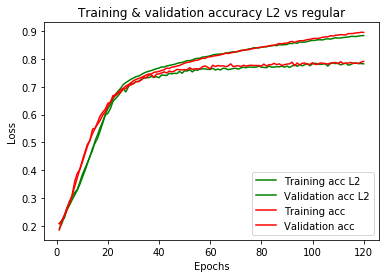

In [29]:
plt.clf()

acc_values = L2_model_dict['acc'] 
val_acc_values = L2_model_dict['val_acc']
model_acc = model_val_dict['acc']
model_val_acc = model_val_dict['val_acc']

epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, 'g', label='Training acc L2')
plt.plot(epochs, val_acc_values, 'g', label='Validation acc L2')
plt.plot(epochs, model_acc, 'r', label='Training acc')
plt.plot(epochs, model_val_acc, 'r', label='Validation acc')
plt.title('Training & validation accuracy L2 vs regular')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The results of L2 regularization are quite disappointing here. We notice the discrepancy between validation and training accuracy seems to have decreased slightly, but the end result is definitely not getting better. 

## L1 Regularization

Let's have a look at L1 regularization. Will this work better?

In [29]:
random.seed(123)
model = models.Sequential()
model.add(layers.Dense(50, activation='relu',kernel_regularizer=regularizers.l1(0.005), input_shape=(2000,))) #2 hidden layers
model.add(layers.Dense(25, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

L1_model = model.fit(train_final,
                    label_train_final,
                    epochs=120,
                    batch_size=256,
                    validation_data=(val, label_val))

Train on 8000 samples, validate on 1000 samples
Epoch 1/120
8000/8000 [==============================] - 1s 125us/step - loss: 16.0173 - acc: 0.1740 - val_loss: 15.5772 - val_acc: 0.1760
Epoch 2/120
8000/8000 [==============================] - 0s 40us/step - loss: 15.2047 - acc: 0.1949 - val_loss: 14.7836 - val_acc: 0.2100
Epoch 3/120
8000/8000 [==============================] - 0s 42us/step - loss: 14.4226 - acc: 0.2190 - val_loss: 14.0150 - val_acc: 0.2450
Epoch 4/120
8000/8000 [==============================] - 0s 43us/step - loss: 13.6644 - acc: 0.2596 - val_loss: 13.2690 - val_acc: 0.2780
Epoch 5/120
8000/8000 [==============================] - 0s 42us/step - loss: 12.9289 - acc: 0.2923 - val_loss: 12.5452 - val_acc: 0.3210
Epoch 6/120
8000/8000 [==============================] - 0s 42us/step - loss: 12.2154 - acc: 0.3375 - val_loss: 11.8433 - val_acc: 0.3530
Epoch 7/120
8000/8000 [==============================] - 0s 43us/step - loss: 11.5250 - acc: 0.3826 - val_loss: 11.1656 - v

8000/8000 [==============================] - 0s 50us/step - loss: 1.6849 - acc: 0.7047 - val_loss: 1.6921 - val_acc: 0.6900
Epoch 61/120
8000/8000 [==============================] - 0s 42us/step - loss: 1.6751 - acc: 0.7039 - val_loss: 1.6771 - val_acc: 0.6890
Epoch 62/120
8000/8000 [==============================] - 0s 44us/step - loss: 1.6652 - acc: 0.7053 - val_loss: 1.6730 - val_acc: 0.6930
Epoch 63/120
8000/8000 [==============================] - 0s 45us/step - loss: 1.6558 - acc: 0.7056 - val_loss: 1.6598 - val_acc: 0.6930
Epoch 64/120
8000/8000 [==============================] - 0s 44us/step - loss: 1.6463 - acc: 0.7065 - val_loss: 1.6517 - val_acc: 0.6940
Epoch 65/120
8000/8000 [==============================] - 0s 42us/step - loss: 1.6377 - acc: 0.7083 - val_loss: 1.6399 - val_acc: 0.6920
Epoch 66/120
8000/8000 [==============================] - 0s 43us/step - loss: 1.6284 - acc: 0.7067 - val_loss: 1.6328 - val_acc: 0.6990
Epoch 67/120
8000/8000 [==============================

8000/8000 [==============================] - 0s 43us/step - loss: 1.2952 - acc: 0.7261 - val_loss: 1.3004 - val_acc: 0.7130
Epoch 118/120
8000/8000 [==============================] - 0s 44us/step - loss: 1.2892 - acc: 0.7268 - val_loss: 1.2990 - val_acc: 0.7140
Epoch 119/120
8000/8000 [==============================] - ETA: 0s - loss: 1.2868 - acc: 0.726 - 0s 42us/step - loss: 1.2852 - acc: 0.7255 - val_loss: 1.2924 - val_acc: 0.7160
Epoch 120/120
8000/8000 [==============================] - 0s 43us/step - loss: 1.2802 - acc: 0.7272 - val_loss: 1.2868 - val_acc: 0.7120


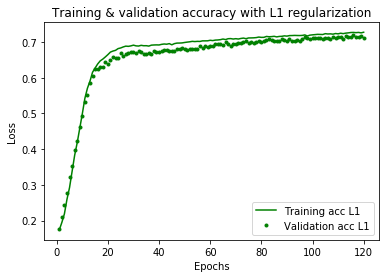

In [30]:
L1_model_dict = L1_model.history
plt.clf()

acc_values = L1_model_dict['acc'] 
val_acc_values = L1_model_dict['val_acc']

epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, 'g', label='Training acc L1')
plt.plot(epochs, val_acc_values, 'g.', label='Validation acc L1')
plt.title('Training & validation accuracy with L1 regularization')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Notice how The training and validation accuracy don't diverge as much as before! Unfortunately, the validation accuracy doesn't reach rates much higher than 70%. It does seem like we can still improve the model by training much longer.

In [31]:
random.seed(123)
model = models.Sequential()
model.add(layers.Dense(50, activation='relu',kernel_regularizer=regularizers.l1(0.005), input_shape=(2000,))) #2 hidden layers
model.add(layers.Dense(25, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

L1_model = model.fit(train_final,
                    label_train_final,
                    epochs=1000,
                    batch_size=256,
                    validation_data=(val, label_val))

Train on 8000 samples, validate on 1000 samples
Epoch 1/1000
8000/8000 [==============================] - 1s 112us/step - loss: 15.9876 - acc: 0.1570 - val_loss: 15.5615 - val_acc: 0.1370
Epoch 2/1000
8000/8000 [==============================] - 0s 40us/step - loss: 15.1791 - acc: 0.1749 - val_loss: 14.7689 - val_acc: 0.1560
Epoch 3/1000
8000/8000 [==============================] - 0s 42us/step - loss: 14.3996 - acc: 0.2057 - val_loss: 14.0030 - val_acc: 0.1870
Epoch 4/1000
8000/8000 [==============================] - 0s 44us/step - loss: 13.6454 - acc: 0.2309 - val_loss: 13.2613 - val_acc: 0.2270
Epoch 5/1000
8000/8000 [==============================] - 0s 42us/step - loss: 12.9149 - acc: 0.2482 - val_loss: 12.5440 - val_acc: 0.2520
Epoch 6/1000
8000/8000 [==============================] - 0s 42us/step - loss: 12.2071 - acc: 0.2706 - val_loss: 11.8491 - val_acc: 0.2510
Epoch 7/1000
8000/8000 [==============================] - 0s 43us/step - loss: 11.5225 - acc: 0.2785 - val_loss: 11.1

8000/8000 [==============================] - 0s 43us/step - loss: 1.7208 - acc: 0.6859 - val_loss: 1.7267 - val_acc: 0.6690
Epoch 60/1000
8000/8000 [==============================] - 0s 44us/step - loss: 1.7106 - acc: 0.6863 - val_loss: 1.7184 - val_acc: 0.6700
Epoch 61/1000
8000/8000 [==============================] - 0s 42us/step - loss: 1.7006 - acc: 0.6868 - val_loss: 1.7065 - val_acc: 0.6710
Epoch 62/1000
8000/8000 [==============================] - 0s 43us/step - loss: 1.6903 - acc: 0.6894 - val_loss: 1.6942 - val_acc: 0.6650
Epoch 63/1000
8000/8000 [==============================] - 0s 42us/step - loss: 1.6806 - acc: 0.6882 - val_loss: 1.6896 - val_acc: 0.6710
Epoch 64/1000
8000/8000 [==============================] - 0s 43us/step - loss: 1.6712 - acc: 0.6903 - val_loss: 1.6800 - val_acc: 0.6680
Epoch 65/1000
8000/8000 [==============================] - 0s 42us/step - loss: 1.6623 - acc: 0.6907 - val_loss: 1.6705 - val_acc: 0.6780
Epoch 66/1000
8000/8000 [=======================

8000/8000 [==============================] - 0s 42us/step - loss: 1.3083 - acc: 0.7133 - val_loss: 1.3207 - val_acc: 0.7060
Epoch 118/1000
8000/8000 [==============================] - 0s 45us/step - loss: 1.3030 - acc: 0.7143 - val_loss: 1.3170 - val_acc: 0.7050
Epoch 119/1000
8000/8000 [==============================] - 0s 43us/step - loss: 1.2985 - acc: 0.7150 - val_loss: 1.3147 - val_acc: 0.6990
Epoch 120/1000
8000/8000 [==============================] - 0s 42us/step - loss: 1.2937 - acc: 0.7155 - val_loss: 1.3074 - val_acc: 0.7090
Epoch 121/1000
8000/8000 [==============================] - 0s 43us/step - loss: 1.2896 - acc: 0.7149 - val_loss: 1.3028 - val_acc: 0.7060
Epoch 122/1000
8000/8000 [==============================] - 0s 42us/step - loss: 1.2841 - acc: 0.7164 - val_loss: 1.2969 - val_acc: 0.7050
Epoch 123/1000
8000/8000 [==============================] - 0s 42us/step - loss: 1.2793 - acc: 0.7160 - val_loss: 1.2973 - val_acc: 0.7020
Epoch 124/1000
8000/8000 [================

Epoch 176/1000
8000/8000 [==============================] - 0s 43us/step - loss: 1.1067 - acc: 0.7373 - val_loss: 1.1269 - val_acc: 0.7220
Epoch 177/1000
8000/8000 [==============================] - 0s 42us/step - loss: 1.1038 - acc: 0.7361 - val_loss: 1.1277 - val_acc: 0.7250
Epoch 178/1000
8000/8000 [==============================] - 0s 42us/step - loss: 1.1024 - acc: 0.7361 - val_loss: 1.1223 - val_acc: 0.7290
Epoch 179/1000
8000/8000 [==============================] - 0s 42us/step - loss: 1.1002 - acc: 0.7368 - val_loss: 1.1207 - val_acc: 0.7240
Epoch 180/1000
8000/8000 [==============================] - 0s 42us/step - loss: 1.0982 - acc: 0.7360 - val_loss: 1.1182 - val_acc: 0.7200
Epoch 181/1000
8000/8000 [==============================] - 0s 42us/step - loss: 1.0964 - acc: 0.7371 - val_loss: 1.1153 - val_acc: 0.7240
Epoch 182/1000
8000/8000 [==============================] - 0s 43us/step - loss: 1.0944 - acc: 0.7373 - val_loss: 1.1145 - val_acc: 0.7280
Epoch 183/1000
8000/8000 [=

8000/8000 [==============================] - 0s 43us/step - loss: 1.0195 - acc: 0.7484 - val_loss: 1.0467 - val_acc: 0.7380
Epoch 235/1000
8000/8000 [==============================] - 0s 44us/step - loss: 1.0193 - acc: 0.7501 - val_loss: 1.0478 - val_acc: 0.7310
Epoch 236/1000
8000/8000 [==============================] - 0s 42us/step - loss: 1.0183 - acc: 0.7475 - val_loss: 1.0466 - val_acc: 0.7300
Epoch 237/1000
8000/8000 [==============================] - 0s 43us/step - loss: 1.0169 - acc: 0.7466 - val_loss: 1.0456 - val_acc: 0.7380
Epoch 238/1000
8000/8000 [==============================] - 0s 42us/step - loss: 1.0158 - acc: 0.7524 - val_loss: 1.0477 - val_acc: 0.7270
Epoch 239/1000
8000/8000 [==============================] - 0s 42us/step - loss: 1.0145 - acc: 0.7511 - val_loss: 1.0433 - val_acc: 0.7370
Epoch 240/1000
8000/8000 [==============================] - 0s 44us/step - loss: 1.0133 - acc: 0.7496 - val_loss: 1.0400 - val_acc: 0.7370
Epoch 241/1000
8000/8000 [================

8000/8000 [==============================] - 0s 42us/step - loss: 0.9695 - acc: 0.7588 - val_loss: 1.0035 - val_acc: 0.7480
Epoch 294/1000
8000/8000 [==============================] - 0s 44us/step - loss: 0.9685 - acc: 0.7560 - val_loss: 1.0023 - val_acc: 0.7410
Epoch 295/1000
8000/8000 [==============================] - 0s 42us/step - loss: 0.9675 - acc: 0.7586 - val_loss: 0.9988 - val_acc: 0.7420
Epoch 296/1000
8000/8000 [==============================] - 0s 42us/step - loss: 0.9673 - acc: 0.7574 - val_loss: 1.0089 - val_acc: 0.7360
Epoch 297/1000
8000/8000 [==============================] - 0s 44us/step - loss: 0.9666 - acc: 0.7599 - val_loss: 1.0079 - val_acc: 0.7410
Epoch 298/1000
8000/8000 [==============================] - 0s 44us/step - loss: 0.9664 - acc: 0.7569 - val_loss: 1.0012 - val_acc: 0.7410
Epoch 299/1000
8000/8000 [==============================] - 0s 42us/step - loss: 0.9654 - acc: 0.7599 - val_loss: 1.0127 - val_acc: 0.7200
Epoch 300/1000
8000/8000 [================

8000/8000 [==============================] - 0s 42us/step - loss: 0.9380 - acc: 0.7640 - val_loss: 0.9782 - val_acc: 0.7450
Epoch 352/1000
8000/8000 [==============================] - 0s 42us/step - loss: 0.9361 - acc: 0.7675 - val_loss: 0.9784 - val_acc: 0.7460
Epoch 353/1000
8000/8000 [==============================] - 0s 43us/step - loss: 0.9362 - acc: 0.7652 - val_loss: 0.9773 - val_acc: 0.7400
Epoch 354/1000
8000/8000 [==============================] - 0s 43us/step - loss: 0.9363 - acc: 0.7650 - val_loss: 0.9758 - val_acc: 0.7430
Epoch 355/1000
8000/8000 [==============================] - 0s 43us/step - loss: 0.9356 - acc: 0.7660 - val_loss: 0.9784 - val_acc: 0.7440
Epoch 356/1000
8000/8000 [==============================] - 0s 43us/step - loss: 0.9346 - acc: 0.7650 - val_loss: 0.9764 - val_acc: 0.7450
Epoch 357/1000
8000/8000 [==============================] - 0s 42us/step - loss: 0.9353 - acc: 0.7669 - val_loss: 0.9762 - val_acc: 0.7390
Epoch 358/1000
8000/8000 [================

8000/8000 [==============================] - 0s 43us/step - loss: 0.9109 - acc: 0.7714 - val_loss: 0.9552 - val_acc: 0.7390
Epoch 410/1000
8000/8000 [==============================] - 0s 42us/step - loss: 0.9119 - acc: 0.7701 - val_loss: 0.9727 - val_acc: 0.7260
Epoch 411/1000
8000/8000 [==============================] - 0s 42us/step - loss: 0.9115 - acc: 0.7705 - val_loss: 0.9603 - val_acc: 0.7390
Epoch 412/1000
8000/8000 [==============================] - 0s 43us/step - loss: 0.9120 - acc: 0.7695 - val_loss: 0.9620 - val_acc: 0.7440
Epoch 413/1000
8000/8000 [==============================] - 0s 42us/step - loss: 0.9107 - acc: 0.7695 - val_loss: 0.9735 - val_acc: 0.7390
Epoch 414/1000
8000/8000 [==============================] - 0s 42us/step - loss: 0.9107 - acc: 0.7704 - val_loss: 0.9567 - val_acc: 0.7460
Epoch 415/1000
8000/8000 [==============================] - 0s 43us/step - loss: 0.9095 - acc: 0.7694 - val_loss: 0.9612 - val_acc: 0.7450
Epoch 416/1000
8000/8000 [================

Epoch 468/1000
8000/8000 [==============================] - 0s 43us/step - loss: 0.8926 - acc: 0.7790 - val_loss: 0.9493 - val_acc: 0.7400
Epoch 469/1000
8000/8000 [==============================] - 0s 42us/step - loss: 0.8912 - acc: 0.7768 - val_loss: 0.9527 - val_acc: 0.7380
Epoch 470/1000
8000/8000 [==============================] - 0s 42us/step - loss: 0.8898 - acc: 0.7765 - val_loss: 0.9444 - val_acc: 0.7410
Epoch 471/1000
8000/8000 [==============================] - 0s 42us/step - loss: 0.8919 - acc: 0.7758 - val_loss: 0.9472 - val_acc: 0.7450
Epoch 472/1000
8000/8000 [==============================] - 0s 44us/step - loss: 0.8903 - acc: 0.7766 - val_loss: 0.9468 - val_acc: 0.7420
Epoch 473/1000
8000/8000 [==============================] - 0s 42us/step - loss: 0.8903 - acc: 0.7789 - val_loss: 0.9498 - val_acc: 0.7400
Epoch 474/1000
8000/8000 [==============================] - 0s 42us/step - loss: 0.8901 - acc: 0.7779 - val_loss: 0.9408 - val_acc: 0.7480
Epoch 475/1000
8000/8000 [=

8000/8000 [==============================] - 0s 43us/step - loss: 0.8748 - acc: 0.7843 - val_loss: 0.9339 - val_acc: 0.7440
Epoch 527/1000
8000/8000 [==============================] - 0s 43us/step - loss: 0.8764 - acc: 0.7840 - val_loss: 0.9468 - val_acc: 0.7430
Epoch 528/1000
8000/8000 [==============================] - 0s 42us/step - loss: 0.8745 - acc: 0.7839 - val_loss: 0.9362 - val_acc: 0.7420
Epoch 529/1000
8000/8000 [==============================] - 0s 43us/step - loss: 0.8741 - acc: 0.7841 - val_loss: 0.9367 - val_acc: 0.7400
Epoch 530/1000
8000/8000 [==============================] - 0s 42us/step - loss: 0.8744 - acc: 0.7844 - val_loss: 0.9348 - val_acc: 0.7500
Epoch 531/1000
8000/8000 [==============================] - 0s 42us/step - loss: 0.8737 - acc: 0.7830 - val_loss: 0.9279 - val_acc: 0.7510
Epoch 532/1000
8000/8000 [==============================] - 0s 42us/step - loss: 0.8756 - acc: 0.7827 - val_loss: 0.9451 - val_acc: 0.7360
Epoch 533/1000
8000/8000 [================

8000/8000 [==============================] - 0s 42us/step - loss: 0.8636 - acc: 0.7915 - val_loss: 0.9371 - val_acc: 0.7450
Epoch 586/1000
8000/8000 [==============================] - 0s 42us/step - loss: 0.8649 - acc: 0.7875 - val_loss: 0.9304 - val_acc: 0.7490
Epoch 587/1000
8000/8000 [==============================] - 0s 43us/step - loss: 0.8646 - acc: 0.7859 - val_loss: 0.9353 - val_acc: 0.7350
Epoch 588/1000
8000/8000 [==============================] - 0s 43us/step - loss: 0.8632 - acc: 0.7875 - val_loss: 0.9347 - val_acc: 0.7420
Epoch 589/1000
8000/8000 [==============================] - 0s 43us/step - loss: 0.8631 - acc: 0.7891 - val_loss: 0.9553 - val_acc: 0.7370
Epoch 590/1000
8000/8000 [==============================] - 0s 42us/step - loss: 0.8638 - acc: 0.7889 - val_loss: 0.9289 - val_acc: 0.7460
Epoch 591/1000
8000/8000 [==============================] - 0s 43us/step - loss: 0.8631 - acc: 0.7896 - val_loss: 0.9349 - val_acc: 0.7490
Epoch 592/1000
8000/8000 [================

Epoch 644/1000
8000/8000 [==============================] - 0s 43us/step - loss: 0.8563 - acc: 0.7946 - val_loss: 0.9328 - val_acc: 0.7410
Epoch 645/1000
8000/8000 [==============================] - 0s 42us/step - loss: 0.8559 - acc: 0.7950 - val_loss: 0.9321 - val_acc: 0.7500
Epoch 646/1000
8000/8000 [==============================] - 0s 43us/step - loss: 0.8559 - acc: 0.7925 - val_loss: 0.9269 - val_acc: 0.7510
Epoch 647/1000
8000/8000 [==============================] - 0s 42us/step - loss: 0.8552 - acc: 0.7939 - val_loss: 0.9251 - val_acc: 0.7530
Epoch 648/1000
8000/8000 [==============================] - 0s 43us/step - loss: 0.8544 - acc: 0.7939 - val_loss: 0.9351 - val_acc: 0.7430
Epoch 649/1000
8000/8000 [==============================] - 0s 42us/step - loss: 0.8537 - acc: 0.7959 - val_loss: 0.9218 - val_acc: 0.7480
Epoch 650/1000
8000/8000 [==============================] - 0s 42us/step - loss: 0.8565 - acc: 0.7924 - val_loss: 0.9218 - val_acc: 0.7520
Epoch 651/1000
8000/8000 [=

8000/8000 [==============================] - 0s 42us/step - loss: 0.8475 - acc: 0.7996 - val_loss: 0.9240 - val_acc: 0.7470
Epoch 703/1000
8000/8000 [==============================] - 0s 42us/step - loss: 0.8470 - acc: 0.7999 - val_loss: 0.9304 - val_acc: 0.7480
Epoch 704/1000
8000/8000 [==============================] - 0s 43us/step - loss: 0.8500 - acc: 0.7974 - val_loss: 0.9306 - val_acc: 0.7490
Epoch 705/1000
8000/8000 [==============================] - 0s 42us/step - loss: 0.8484 - acc: 0.7989 - val_loss: 0.9360 - val_acc: 0.7520
Epoch 706/1000
8000/8000 [==============================] - 0s 42us/step - loss: 0.8467 - acc: 0.8011 - val_loss: 0.9484 - val_acc: 0.7400
Epoch 707/1000
8000/8000 [==============================] - 0s 42us/step - loss: 0.8516 - acc: 0.7941 - val_loss: 0.9294 - val_acc: 0.7530
Epoch 708/1000
8000/8000 [==============================] - 0s 42us/step - loss: 0.8454 - acc: 0.7991 - val_loss: 0.9550 - val_acc: 0.7500
Epoch 709/1000
8000/8000 [================

Epoch 761/1000
8000/8000 [==============================] - 0s 48us/step - loss: 0.8424 - acc: 0.8023 - val_loss: 1.0174 - val_acc: 0.7210
Epoch 762/1000
8000/8000 [==============================] - 0s 42us/step - loss: 0.8467 - acc: 0.8013 - val_loss: 0.9211 - val_acc: 0.7570
Epoch 763/1000
8000/8000 [==============================] - 0s 42us/step - loss: 0.8438 - acc: 0.8007 - val_loss: 0.9218 - val_acc: 0.7450
Epoch 764/1000
8000/8000 [==============================] - 0s 44us/step - loss: 0.8403 - acc: 0.8025 - val_loss: 0.9285 - val_acc: 0.7530
Epoch 765/1000
8000/8000 [==============================] - 0s 43us/step - loss: 0.8439 - acc: 0.8046 - val_loss: 0.9485 - val_acc: 0.7520
Epoch 766/1000
8000/8000 [==============================] - 0s 42us/step - loss: 0.8450 - acc: 0.7989 - val_loss: 0.9262 - val_acc: 0.7560
Epoch 767/1000
8000/8000 [==============================] - 0s 42us/step - loss: 0.8407 - acc: 0.8017 - val_loss: 0.9247 - val_acc: 0.7560
Epoch 768/1000
8000/8000 [=

Epoch 820/1000
8000/8000 [==============================] - 0s 42us/step - loss: 0.8352 - acc: 0.8054 - val_loss: 0.9436 - val_acc: 0.7440
Epoch 821/1000
8000/8000 [==============================] - 0s 43us/step - loss: 0.8345 - acc: 0.8055 - val_loss: 0.9364 - val_acc: 0.7550
Epoch 822/1000
8000/8000 [==============================] - 0s 43us/step - loss: 0.8368 - acc: 0.8039 - val_loss: 0.9309 - val_acc: 0.7460
Epoch 823/1000
8000/8000 [==============================] - 0s 43us/step - loss: 0.8353 - acc: 0.8055 - val_loss: 0.9222 - val_acc: 0.7570
Epoch 824/1000
8000/8000 [==============================] - 0s 43us/step - loss: 0.8336 - acc: 0.8065 - val_loss: 0.9182 - val_acc: 0.7590
Epoch 825/1000
8000/8000 [==============================] - 0s 42us/step - loss: 0.8355 - acc: 0.8043 - val_loss: 0.9398 - val_acc: 0.7490
Epoch 826/1000
8000/8000 [==============================] - 0s 42us/step - loss: 0.8336 - acc: 0.8061 - val_loss: 0.9543 - val_acc: 0.7430
Epoch 827/1000
8000/8000 [=

Epoch 879/1000
8000/8000 [==============================] - 0s 42us/step - loss: 0.8270 - acc: 0.8116 - val_loss: 0.9214 - val_acc: 0.7470
Epoch 880/1000
8000/8000 [==============================] - 0s 43us/step - loss: 0.8298 - acc: 0.8085 - val_loss: 0.9222 - val_acc: 0.7550
Epoch 881/1000
8000/8000 [==============================] - 0s 43us/step - loss: 0.8326 - acc: 0.8088 - val_loss: 0.9437 - val_acc: 0.7560
Epoch 882/1000
8000/8000 [==============================] - 0s 42us/step - loss: 0.8317 - acc: 0.8067 - val_loss: 0.9914 - val_acc: 0.7180
Epoch 883/1000
8000/8000 [==============================] - 0s 42us/step - loss: 0.8333 - acc: 0.8100 - val_loss: 0.9220 - val_acc: 0.7540
Epoch 884/1000
8000/8000 [==============================] - 0s 42us/step - loss: 0.8284 - acc: 0.8106 - val_loss: 0.9277 - val_acc: 0.7530
Epoch 885/1000
8000/8000 [==============================] - 0s 42us/step - loss: 0.8365 - acc: 0.8061 - val_loss: 0.9876 - val_acc: 0.7270
Epoch 886/1000
8000/8000 [=

Epoch 938/1000
8000/8000 [==============================] - 0s 43us/step - loss: 0.8269 - acc: 0.8110 - val_loss: 0.9520 - val_acc: 0.7450
Epoch 939/1000
8000/8000 [==============================] - 0s 42us/step - loss: 0.8256 - acc: 0.8123 - val_loss: 0.9292 - val_acc: 0.7410
Epoch 940/1000
8000/8000 [==============================] - 0s 42us/step - loss: 0.8245 - acc: 0.8147 - val_loss: 0.9468 - val_acc: 0.7470
Epoch 941/1000
8000/8000 [==============================] - 0s 43us/step - loss: 0.8235 - acc: 0.8143 - val_loss: 0.9330 - val_acc: 0.7540
Epoch 942/1000
8000/8000 [==============================] - 0s 42us/step - loss: 0.8217 - acc: 0.8174 - val_loss: 0.9221 - val_acc: 0.7610
Epoch 943/1000
8000/8000 [==============================] - 0s 42us/step - loss: 0.8204 - acc: 0.8160 - val_loss: 0.9435 - val_acc: 0.7490
Epoch 944/1000
8000/8000 [==============================] - 0s 43us/step - loss: 0.8240 - acc: 0.8132 - val_loss: 0.9866 - val_acc: 0.7440
Epoch 945/1000
8000/8000 [=

8000/8000 [==============================] - 0s 42us/step - loss: 0.8198 - acc: 0.8171 - val_loss: 0.9238 - val_acc: 0.7480
Epoch 997/1000
8000/8000 [==============================] - 0s 43us/step - loss: 0.8202 - acc: 0.8166 - val_loss: 0.9763 - val_acc: 0.7380
Epoch 998/1000
8000/8000 [==============================] - 0s 42us/step - loss: 0.8207 - acc: 0.8175 - val_loss: 0.9212 - val_acc: 0.7570
Epoch 999/1000
8000/8000 [==============================] - 0s 42us/step - loss: 0.8169 - acc: 0.8177 - val_loss: 0.9481 - val_acc: 0.7470
Epoch 1000/1000
8000/8000 [==============================] - 0s 43us/step - loss: 0.8168 - acc: 0.8166 - val_loss: 0.9199 - val_acc: 0.7450


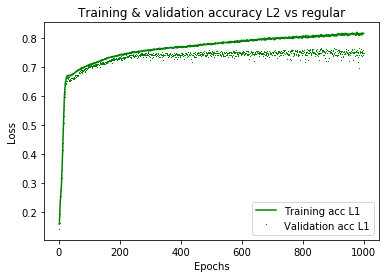

In [32]:
L1_model_dict = L1_model.history
plt.clf()

acc_values = L1_model_dict['acc'] 
val_acc_values = L1_model_dict['val_acc']

epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, 'g', label='Training acc L1')
plt.plot(epochs, val_acc_values, 'g,', label='Validation acc L1')
plt.title('Training & validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [35]:
results_train = model.evaluate(train_final, label_train_final)

results_test = model.evaluate(X_test, y_test)

1500/1500 [==============================] - 0s 26us/step


In [36]:
results_train

[0.8237653533299764, 0.7967999999682108]

In [37]:
results_test

[0.966706668694814, 0.7499999998410543]

This is about the best we've seen so far, but we were training for quite a while! Let's see if dropout regularization can do even better and/or be more efficient!

## Dropout Regularization

In [47]:
random.seed(123)
model = models.Sequential()
model.add(layers.Dropout(0.3, input_shape=(2000,)))
model.add(layers.Dense(50, activation='relu')) #2 hidden layers
model.add(layers.Dropout(0.3))
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

dropout_model = model.fit(train_final,
                    label_train_final,
                    epochs=200,
                    batch_size=256,
                    validation_data=(val, label_val))

Train on 8000 samples, validate on 1000 samples
Epoch 1/200
8000/8000 [==============================] - 1s 186us/step - loss: 1.9668 - acc: 0.1470 - val_loss: 1.9344 - val_acc: 0.1620 0s - loss: 1.9675 - acc: 0.146
Epoch 2/200
8000/8000 [==============================] - 0s 55us/step - loss: 1.9511 - acc: 0.1556 - val_loss: 1.9259 - val_acc: 0.1810
Epoch 3/200
8000/8000 [==============================] - 0s 57us/step - loss: 1.9412 - acc: 0.1584 - val_loss: 1.9189 - val_acc: 0.1940
Epoch 4/200
8000/8000 [==============================] - 0s 57us/step - loss: 1.9357 - acc: 0.1665 - val_loss: 1.9122 - val_acc: 0.2040
Epoch 5/200
8000/8000 [==============================] - 0s 56us/step - loss: 1.9264 - acc: 0.1792 - val_loss: 1.9053 - val_acc: 0.2100
Epoch 6/200
8000/8000 [==============================] - ETA: 0s - loss: 1.9244 - acc: 0.177 - 0s 58us/step - loss: 1.9238 - acc: 0.1789 - val_loss: 1.8989 - val_acc: 0.2240
Epoch 7/200
8000/8000 [==============================] - 0s 56us/s

8000/8000 [==============================] - 0s 57us/step - loss: 1.2316 - acc: 0.5349 - val_loss: 0.9702 - val_acc: 0.7020
Epoch 61/200
8000/8000 [==============================] - 0s 57us/step - loss: 1.2205 - acc: 0.5477 - val_loss: 0.9616 - val_acc: 0.7060
Epoch 62/200
8000/8000 [==============================] - 0s 55us/step - loss: 1.2188 - acc: 0.5505 - val_loss: 0.9514 - val_acc: 0.7030
Epoch 63/200
8000/8000 [==============================] - 0s 55us/step - loss: 1.2202 - acc: 0.5485 - val_loss: 0.9435 - val_acc: 0.7100
Epoch 64/200
8000/8000 [==============================] - 0s 56us/step - loss: 1.1886 - acc: 0.5525 - val_loss: 0.9323 - val_acc: 0.7090
Epoch 65/200
8000/8000 [==============================] - 0s 54us/step - loss: 1.1904 - acc: 0.5509 - val_loss: 0.9255 - val_acc: 0.7110
Epoch 66/200
8000/8000 [==============================] - 0s 57us/step - loss: 1.1868 - acc: 0.5564 - val_loss: 0.9156 - val_acc: 0.7100
Epoch 67/200
8000/8000 [==============================

8000/8000 [==============================] - 0s 55us/step - loss: 0.9304 - acc: 0.6598 - val_loss: 0.6924 - val_acc: 0.7480
Epoch 120/200
8000/8000 [==============================] - 0s 56us/step - loss: 0.9173 - acc: 0.6633 - val_loss: 0.6900 - val_acc: 0.7500
Epoch 121/200
8000/8000 [==============================] - 0s 54us/step - loss: 0.9239 - acc: 0.6606 - val_loss: 0.6888 - val_acc: 0.7490
Epoch 122/200
8000/8000 [==============================] - 0s 55us/step - loss: 0.9166 - acc: 0.6626 - val_loss: 0.6892 - val_acc: 0.7490
Epoch 123/200
8000/8000 [==============================] - 0s 55us/step - loss: 0.9198 - acc: 0.6654 - val_loss: 0.6839 - val_acc: 0.7480
Epoch 124/200
8000/8000 [==============================] - 0s 55us/step - loss: 0.9071 - acc: 0.6675 - val_loss: 0.6809 - val_acc: 0.7470
Epoch 125/200
8000/8000 [==============================] - 0s 55us/step - loss: 0.8995 - acc: 0.6720 - val_loss: 0.6779 - val_acc: 0.7480
Epoch 126/200
8000/8000 [=======================

8000/8000 [==============================] - 0s 56us/step - loss: 0.7836 - acc: 0.7094 - val_loss: 0.6154 - val_acc: 0.7610
Epoch 179/200
8000/8000 [==============================] - 0s 54us/step - loss: 0.7963 - acc: 0.7111 - val_loss: 0.6185 - val_acc: 0.7610
Epoch 180/200
8000/8000 [==============================] - 0s 54us/step - loss: 0.7752 - acc: 0.7130 - val_loss: 0.6172 - val_acc: 0.7600
Epoch 181/200
8000/8000 [==============================] - 0s 55us/step - loss: 0.7818 - acc: 0.7191 - val_loss: 0.6107 - val_acc: 0.7670
Epoch 182/200
8000/8000 [==============================] - 0s 55us/step - loss: 0.7918 - acc: 0.7146 - val_loss: 0.6116 - val_acc: 0.7640
Epoch 183/200
8000/8000 [==============================] - ETA: 0s - loss: 0.7734 - acc: 0.719 - 0s 55us/step - loss: 0.7764 - acc: 0.7186 - val_loss: 0.6102 - val_acc: 0.7650
Epoch 184/200
8000/8000 [==============================] - 0s 55us/step - loss: 0.7848 - acc: 0.7099 - val_loss: 0.6128 - val_acc: 0.7600
Epoch 185/

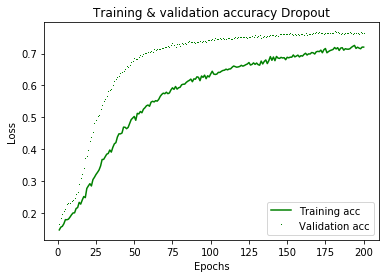

In [48]:
dropout_model_dict = dropout_model.history
plt.clf()

acc_values = dropout_model_dict['acc'] 
val_acc_values = dropout_model_dict['val_acc']

epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, 'g', label='Training acc')
plt.plot(epochs, val_acc_values, 'g,', label='Validation acc')
plt.title('Training & validation accuracy Dropout')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [49]:
results_train = model.evaluate(train_final, label_train_final)
results_test = model.evaluate(X_test, y_test)

1000/1000 [==============================] - 0s 36us/step


In [50]:
results_train

[0.4637945830821991, 0.836]

In [51]:
results_test

[0.6121579809188843, 0.769]

You can see here that the validation performance has improved again! the variance did become higher again compared to L1-regularization.

## Bigger Data?

In the lecture, one of the solutions to high variance was just getting more data. We actually *have* more data, but took a subset of 10,000 units before. Let's now quadruple our data set, and see what happens. Note that we are really just lucky here, and getting more data isn't always possible, but this is a useful exercise in order to understand the power of big data sets.

In [52]:
df = pd.read_csv('Bank_complaints.csv')
random.seed(123)
df = df.sample(40000)
df.index = range(40000)
product = df["Product"]
complaints = df["Consumer complaint narrative"]

#one-hot encoding of the complaints
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(complaints)
sequences = tokenizer.texts_to_sequences(complaints)
one_hot_results= tokenizer.texts_to_matrix(complaints, mode='binary')
word_index = tokenizer.word_index
np.shape(one_hot_results)

#one-hot encoding of products
le = preprocessing.LabelEncoder()
le.fit(product)
list(le.classes_)
product_cat = le.transform(product) 
product_onehot = to_categorical(product_cat)

# train test split
test_index = random.sample(range(1,40000), 4000)
test = one_hot_results[test_index]
train = np.delete(one_hot_results, test_index, 0)
label_test = product_onehot[test_index]
label_train = np.delete(product_onehot, test_index, 0)

#Validation set
random.seed(123)
val = train[:3000]
train_final = train[3000:]
label_val = label_train[:3000]
label_train_final = label_train[3000:]

In [53]:
random.seed(123)
model = models.Sequential()
model.add(layers.Dense(50, activation='relu', input_shape=(2000,))) #2 hidden layers
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

moredata_model = model.fit(train_final,
                    label_train_final,
                    epochs=120,
                    batch_size=256,
                    validation_data=(val, label_val))

Train on 33000 samples, validate on 3000 samples
Epoch 1/120
33000/33000 [==============================] - 2s 63us/step - loss: 1.9038 - acc: 0.2067 - val_loss: 1.8667 - val_acc: 0.2417
Epoch 2/120
33000/33000 [==============================] - 1s 39us/step - loss: 1.8195 - acc: 0.2877 - val_loss: 1.7589 - val_acc: 0.3473
Epoch 3/120
33000/33000 [==============================] - 1s 41us/step - loss: 1.6767 - acc: 0.4079 - val_loss: 1.5814 - val_acc: 0.4827
Epoch 4/120
33000/33000 [==============================] - ETA: 0s - loss: 1.4818 - acc: 0.523 - 1s 40us/step - loss: 1.4790 - acc: 0.5246 - val_loss: 1.3704 - val_acc: 0.5763
Epoch 5/120
33000/33000 [==============================] - 1s 41us/step - loss: 1.2650 - acc: 0.6138 - val_loss: 1.1672 - val_acc: 0.6423
Epoch 6/120
33000/33000 [==============================] - 1s 40us/step - loss: 1.0804 - acc: 0.6700 - val_loss: 1.0129 - val_acc: 0.6783
Epoch 7/120
33000/33000 [==============================] - 1s 39us/step - loss: 0.946

Epoch 58/120
33000/33000 [==============================] - 1s 39us/step - loss: 0.4057 - acc: 0.8571 - val_loss: 0.5385 - val_acc: 0.8137
Epoch 59/120
33000/33000 [==============================] - 1s 41us/step - loss: 0.4031 - acc: 0.8578 - val_loss: 0.5375 - val_acc: 0.8120
Epoch 60/120
33000/33000 [==============================] - 1s 40us/step - loss: 0.4006 - acc: 0.8582 - val_loss: 0.5383 - val_acc: 0.8113
Epoch 61/120
33000/33000 [==============================] - 1s 39us/step - loss: 0.3983 - acc: 0.8594 - val_loss: 0.5376 - val_acc: 0.8140
Epoch 62/120
33000/33000 [==============================] - 1s 40us/step - loss: 0.3961 - acc: 0.8602 - val_loss: 0.5401 - val_acc: 0.8097
Epoch 63/120
33000/33000 [==============================] - 1s 39us/step - loss: 0.3941 - acc: 0.8618 - val_loss: 0.5373 - val_acc: 0.8150
Epoch 64/120
33000/33000 [==============================] - 1s 39us/step - loss: 0.3918 - acc: 0.8621 - val_loss: 0.5372 - val_acc: 0.8150
Epoch 65/120
33000/33000 [=

33000/33000 [==============================] - 1s 40us/step - loss: 0.3126 - acc: 0.8917 - val_loss: 0.5712 - val_acc: 0.8127
Epoch 116/120
33000/33000 [==============================] - 1s 40us/step - loss: 0.3115 - acc: 0.8911 - val_loss: 0.5749 - val_acc: 0.8130
Epoch 117/120
33000/33000 [==============================] - 1s 39us/step - loss: 0.3100 - acc: 0.8919 - val_loss: 0.5789 - val_acc: 0.8130
Epoch 118/120
33000/33000 [==============================] - 1s 38us/step - loss: 0.3092 - acc: 0.8920 - val_loss: 0.5746 - val_acc: 0.8110
Epoch 119/120
33000/33000 [==============================] - 1s 38us/step - loss: 0.3076 - acc: 0.8932 - val_loss: 0.5772 - val_acc: 0.8130
Epoch 120/120
33000/33000 [==============================] - 1s 39us/step - loss: 0.3064 - acc: 0.8937 - val_loss: 0.5799 - val_acc: 0.8123


In [54]:
results_train = model.evaluate(train_final, label_train_final)
results_test = model.evaluate(test, label_test)

4000/4000 [==============================] - 0s 32us/step


In [55]:
results_train

[0.30179671092105637, 0.8958484848484849]

In [56]:
results_test

[0.5763684837818146, 0.79875]

With the same amount of epochs, we were able to get a fairly similar validation accuracy of 89.67 (compared to 88.55 in obtained in the first model in this lab). Our test set accuracy went up from 75.8 to a staggering 80.225% though, without any other regularization technique. You can still consider early stopping, L1, L2 and dropout here. It's clear that having more data has a strong impact on model performance!

## Additional Resources

* https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Consumer_complaints.ipynb
* https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/
* https://catalog.data.gov/dataset/consumer-complaint-database

## Summary  

In this lesson, we not only built an initial deep-learning model, we then used a validation set to tune our model using various types of regularization. From here, we'll continue to describe more practice and theory regarding tuning and optimizing deep-learning networks.